<font size="10">
Quadratic map from segmented linear maps
</font>

Derivation of how to create a estimator of quadratic bias field from linearly projected shells.

See Chapter 1 and 2 in the notes: https://www.overleaf.com/read/pjpctxdxgrbk#002f29.

# Initialise

In [15]:
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('dark_background')
np.set_printoptions(linewidth=1000)
from numpy.fft import fftn, fftfreq, ifftn
import seaborn

# Functions

## Field generator

In [16]:
# ----------------------------------------------------------------------
# 1.  Build k‑ and x‑space helper grids once
# ----------------------------------------------------------------------
def _grids(N, L):
    dx  = L / N
    k1d = fftfreq(N, d=dx) * 2*np.pi
    kx, ky, kz = np.meshgrid(k1d, k1d, k1d, indexing='ij')
    k_mag = np.sqrt(kx**2 + ky**2 + kz**2)
    return k_mag, dx

# ----------------------------------------------------------------------
# 2.  P_G(k) from P_Δ(k)  (Eq. 3)
# ----------------------------------------------------------------------
def gaussian_surrogate_power(N, L, P_Δ, clip_eps=1e-10):
    """
    Return the discrete lattice values of P_G(k) that reproduce
    the requested log‑normal spectrum P_Δ(k).

    Parameters
    ----------
    N, L : int, float
        Grid size and box length.
    P_Δ : callable
        Function P_Δ(k) → P_Δ(k).
    clip_eps : float
        Small positive floor to keep 1+ξ_Δ(r) > 0 before taking the log.

    Returns
    -------
    P_G : ndarray, shape (N, N, N)
        Gaussian surrogate power on the full complex lattice.
    σ_G2 : float
        Variance σ_G² = ξ_G(0) (useful for consistency checks).
    """
    k_mag, dx = _grids(N, L)
    # ---- 2.1  ξ_Δ(r) via inverse FFT ---------------------------------
    P_Δ_grid = P_Δ(k_mag)
    P_Δ_grid[0,0,0] = 0.0                     # remove k=0: already fixed <Δ>=1
    ξ_Δ = ifftn(P_Δ_grid / dx**3).real   # Eq.(2) with discrete sum → integral
    # ---- 2.2  ξ_G(r) --------------------------------------------------
    arg = 1.0 + ξ_Δ
    if (arg <= 0.0).any():
        # numerical safety: push tiny negatives to +clip_eps
        arg = np.where(arg > 0.0, arg, clip_eps)
    ξ_G = np.log(arg)
    σ_G2 = ξ_G[0,0,0]
    # ---- 2.3  P_G(k) via FFT -----------------------------------------
    P_G_grid = fftn(ξ_G) * dx**3                 # back to k‑space, Eq.(3)
    P_G_grid = P_G_grid.real
    P_G_grid[P_G_grid < 0.0] = 0.0                # clip tiny negative noise
    P_G_grid[0,0,0] = 0.0                         # enforce <G>=0 in k‑space
    return P_G_grid, k_mag, σ_G2

# ----------------------------------------------------------------------
# 3.  Draw the log‑normal field from P_Δ(k)   (wrapper)
# ----------------------------------------------------------------------
def generate_lognormal_from_PΔ(N, L, P_Δ_func, seed=None, print_stats=False):
    """
    Generate Δ(x) with target spectrum P_Δ(k) on an N³ periodic grid.

    Parameters
    ----------
    N, L : int, float
        Grid size and box length.
    P_Δ_func : callable
        Function P_Δ_func(k) returning the target log‑normal spectrum.
    seed : int or None
        RNG seed.
    enforce_mean : bool
        Re‑normalise realisation to ⟨Δ⟩ = 1 exactly.

    Returns
    -------
    Delta : ndarray, shape (N,N,N)
        The log‑normal field values Δ(x)>0.
    P_G   : ndarray, shape (N,N,N)
        Gaussian surrogate power that was internally used.
    """

    np.random.seed(seed)

    # 3.1  Get P_G(k) on the full lattice
    P_G_grid, k_mag, σ_G2 = gaussian_surrogate_power(N, L, P_Δ_func)
    μ_G = -0.5 * σ_G2                         # ensures ⟨Δ⟩ = 1 analytically

    # 3.2  Work on the half‑complex grid for memory efficiency
    P_G_half = P_G_grid[:, :, :N//2 + 1]           # rFFT target

    # 3.3  Draw Gaussian Fourier modes
    L3 = L**3
    amp = np.sqrt(0.5 * L3 * P_G_half)
    gk = (np.random.normal(size=amp.shape).astype(np.float32) + 1j * np.random.normal(size=amp.shape).astype(np.float32)) * amp

    # purely real planes (k_z = 0 or Nyquist) carry no imaginary part
    pure_real = (np.arange(N//2 + 1) == 0) | (np.arange(N//2 + 1) == N//2)
    gk[:, :, pure_real] = (np.random.normal(size=gk[:, :, pure_real].shape).astype(np.float32) * np.sqrt(L3 * P_G_half[:, :, pure_real]))
    gk[0,0,0] = 0.0                                # enforce ⟨G⟩ = 0

    # 3.4  Transform to real space, impose variance and mean
    G = np.fft.irfftn(gk, s=(N, N, N))
    G -= G.mean()
    G *= np.sqrt(σ_G2 / G.var())               # matches target σ_G²
    G += μ_G                                      # shift mean

    Δ = np.exp(G)

    k_Δ, P_Δ = power_spectrum_Δ(Δ, L=L, nbin=N)
    P_input = P_Δ_func(k_Δ)
    x_Δ = np.linspace(0, L, N)

    if print_stats:
        print("x_Δ min max dx", x_Δ.min(), x_Δ.max(), x_Δ[1]-x_Δ[0])
        print("⟨Δ⟩ =", Δ.mean())
        print("Var(Δ) =", Δ.var())
        print("Std(Δ) =", Δ.std())
        print("Δ size", Δ.nbytes/1e9, "GB")

    return Δ, P_input, P_Δ, k_Δ, x_Δ

In [17]:
# simple power‑law spectrum  P(k) = A kⁿ  
def Pk_powerlaw(k, A=1.0, n=-1):
    return A * np.where(k > 0, k**n, 0.0)

def Pk_cosmology(k):

    import pyccl as ccl

    # Define cosmological parameters
    cosmo = ccl.Cosmology(
        Omega_c=0.3075 - 0.0486,  # Cold dark matter density parameter
        Omega_b=0.0486,  # Baryon density parameter
        Omega_k=0.0,  # Curvature parameter (set to 0 for flat universe)
        h=0.678,  # Hubble constant in units of 100 km/s/Mpc
        n_s=0.967,  # Spectral index
        sigma8=0.815,  # Amplitude of matter power spectrum at 8 Mpc/h
        transfer_function='eisenstein_hu'  # Transfer function model
    )

    z = 1
    k_vec = k.ravel()
    P_k_values = ccl.nonlin_matter_power(cosmo, k_vec, a=1/(1+z))
    P_k_values = P_k_values.reshape(k.shape)
    return P_k_values

def beta_kernel(N, alpha=2, beta=2):
    """
    Create a beta distribution kernel on N sample points.
    
    Parameters:
    -----------
    N : int
        Number of sample points
    alpha : float
        First shape parameter of beta distribution
    beta : float
        Second shape parameter of beta distribution
        
    Returns:
    --------
    kernel : ndarray
        1D array of length N containing the beta distribution
    """
    x = np.linspace(0, 1, N)
    kernel = (x**(alpha-1) * (1-x)**(beta-1))
    # Normalize
    kernel = kernel / np.sum(kernel)
    return kernel

In [18]:
def get_increasing_sequence(Z, num_pix):
    seq = np.full(Z, num_pix/Z, dtype=int)
    n_updates = 100
    for i in range(n_updates):
        for j in range(i+1):
            seq[-j-1] += 1
            seq[j] -= 1
        if seq[0]<=2:
            break

    print(np.sum(seq), seq)
    return seq

## Power specturm measurements

In [19]:
def radial_cross_power_spectrum(I1: np.ndarray,
                                I2: np.ndarray,
                                dx: float = 1.0,
                                nbins: int | None = None,
                                *,
                                complex_output: bool = False
                               ):
    """Return (k, P(k)) – radially averaged cross‑power spectrum."""
    if I1.shape != I2.shape or I1.ndim != 2 or I1.shape[0] != I1.shape[1]:
        raise ValueError("I1 and I2 must be square arrays with identical shape (N×N)")
    N = I1.shape[0]
    if nbins is None:
        nbins = N // 2                      # one annulus per independent k

    # 2‑D FFTs
    F1 = np.fft.fftshift(np.fft.fft2(I1))
    F2 = np.fft.fftshift(np.fft.fft2(I2))
    CS = F1 * np.conj(F2) / (N * N)        # normalised cross‑spectrum

    # radial coordinate grid
    kfreq = np.fft.fftshift(np.fft.fftfreq(N, d=dx))
    kx, ky = np.meshgrid(kfreq, kfreq, indexing="xy")
    kr = np.sqrt(kx**2 + ky**2).ravel()

    # binning
    CS = CS.ravel()
    edges   = np.linspace(0.0, kr.max(), nbins + 1)
    centers = 0.5*(edges[:-1] + edges[1:])

    real_accum = np.zeros(nbins, dtype=np.float64)
    imag_accum = np.zeros(nbins, dtype=np.float64)
    counts     = np.zeros(nbins, dtype=np.int64)

    idx    = np.digitize(kr, edges) - 1
    valid  = (idx >= 0) & (idx < nbins)
    np.add.at(real_accum, idx[valid], CS.real[valid])
    np.add.at(imag_accum, idx[valid], CS.imag[valid])
    np.add.at(counts,     idx[valid], 1)

    nz = counts > 0
    real_accum[nz] /= counts[nz]
    imag_accum[nz] /= counts[nz]

    Pk = real_accum + 1j*imag_accum
    if not complex_output:
        Pk = np.abs(Pk)

    return centers[nz], Pk[nz]

def test_power_spectrum_2d():
        
    # ------------------------------------------------------------
    # Test: power‑law input spectrum  P_in(k) ∝ k^(-α)
    # ------------------------------------------------------------
    N     = 256          # grid size
    dx    = 1.0          # physical pixel size
    alpha = 3.0          # power‑law slope
    rng   = np.random.default_rng(0)

    # Wave‑number grid
    freq = np.fft.fftfreq(N, d=dx)
    kx, ky = np.meshgrid(freq, freq, indexing='xy')
    kr = np.sqrt(kx**2 + ky**2)

    # Input power spectrum on full grid (P_in(k) = k^(-α))
    P_full = (kr + 1e-10)**(-alpha)     # add ε to avoid singularity at k=0
    P_full[kr == 0] = 0.0               # zero mean

    # ---------- build one Gaussian random field -----------------
    #  • start with white noise in real space
    w   = rng.standard_normal((N, N))
    Fw  = np.fft.fft2(w)

    #  • colour it: multiply by sqrt(P_in) in Fourier space
    F   = Fw * np.sqrt(P_full)

    #  • transform back to get the field (real part only)
    field = np.fft.ifft2(F).real

    # ---------- estimate spectrum -------------------------------
    k_centres, P_est = radial_cross_power_spectrum(field, field, dx=dx)

    # Theoretical spectrum at the same sampled k
    P_theory = (k_centres + 1e-10)**(-alpha)

    # ------------------------------------------------------------
    # Plot: input vs. estimated spectrum
    # ------------------------------------------------------------
    plt.figure()
    plt.loglog(k_centres, P_theory, label='Input  $P_{\\rm in}(k) \\propto k^{-%g}$' % alpha)
    plt.loglog(k_centres, P_est,   '--', label='Estimated  $P_{\\rm est}(k)$')
    plt.xlabel('$k$  (cycles per unit length)')
    plt.ylabel('$P(k)$')
    plt.title('Power‑law spectrum test ($N=%d$, one realisation)' % N)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------
    # Plot: ratio  P_est / P_in  (should hover around 1)
    # ------------------------------------------------------------
    plt.figure()
    plt.loglog(k_centres, P_est / P_theory)
    plt.axhline(1.0, linestyle='--')
    plt.ylim(0.1, 10)
    plt.xlabel('$k$')
    plt.ylabel('$P_{\\rm est}/P_{\\rm in}$')
    plt.title('Ratio: estimated / input power')
    plt.tight_layout()
    plt.show()


In [20]:
def power_spectrum_Δ(field, L, nbin=40, k_min=None, k_max=None, return_k_edges=False):
    """
    Compute the isotropised power spectrum of a 3‑D field in
    the same units as the input spectrum P(k).

    Parameters
    ----------
    field : ndarray, shape (N, N, N)
        Real‑space voxels of Δ(x). Must be on a cubic, periodic grid.
    L : float
        Physical size of the box along each axis (same units as ε and k⁻¹).
    nbin : int, optional
        Number of k‑bins for the 1‑D spectrum.
    k_min, k_max : float or None
        If supplied, restrict output to this k‑range (in absolute units).
        Defaults: k_min = fundamental mode, k_max = Nyquist.
    return_k_edges : bool, optional
        If True, also returns the lower & upper k‑edges of each bin.

    Returns
    -------
    k_centers : ndarray, shape (nbin,)
        Mid‑point (geometric mean) of each k‑bin.
    Pk : ndarray, shape (nbin,)
        Power spectrum ⟨|Δ̃(k)|²⟩/V in the same units as the input P(k).
    k_edges : ndarray, shape (nbin+1,), optional
        Bin edges (only if return_k_edges=True).
    """
    N = field.shape[0]
    assert field.shape == (N, N, N), "Field must be cubic"
    V   = L**3
    dx  = L / N
    dk  = 2 * np.pi / L

    # ------------------------------------------------------------------
    # 1. Fourier transform (complex-valued).
    #    NumPy's fftn has no prefactor; ifftn divides by N³.
    # ------------------------------------------------------------------
    Δ_k = fftn(field)

    # ------------------------------------------------------------------
    # 2. Convert to *continuum* normalisation:
    #       Δ̃_cont(k)  ≈  dx³ · Δ_k_numpy
    #    so that P(k) = |Δ̃|² / V .
    # ------------------------------------------------------------------
    Δ_k *= dx**3                      # same as multiplying by cell volume
    power_k = (np.abs(Δ_k)**2) / V    # |Δ̃|² / V

    # ------------------------------------------------------------------
    # 3. Build k‑grid (same ordering as fftfreq).
    # ------------------------------------------------------------------
    k1d = fftfreq(N, d=dx) * 2*np.pi      # [-k_Nyq, ..., +k_Nyq]
    kx, ky, kz = np.meshgrid(k1d, k1d, k1d, indexing='ij')
    k_mag = np.sqrt(kx**2 + ky**2 + kz**2)

    # Discard the k = 0 mode — it carries the mean (<Δ>=1) not fluctuations.
    mask = (k_mag > 0)
    k_vals   = k_mag[mask].ravel()
    P_vals   = power_k[mask].ravel()

    # ------------------------------------------------------------------
    # 4. Bin in |k|.  Use logarithmic spacing by default (geometric mean).
    # ------------------------------------------------------------------
    if k_min is None:
        k_min = dk                           # fundamental mode
    if k_max is None:
        k_max = np.pi * N / L                # Nyquist

    k_edges = np.geomspace(k_min, k_max, nbin + 1)
    # assign each mode to a shell
    indices = np.searchsorted(k_edges, k_vals, side='right') - 1
    valid   = (indices >= 0) & (indices < nbin)

    # sum power and number of modes per bin
    Pk_sum  = np.bincount(indices[valid], weights=P_vals[valid], minlength=nbin)
    N_modes = np.bincount(indices[valid], minlength=nbin)

    # avoid division by zero where there are no modes
    with np.errstate(divide="ignore", invalid="ignore"):
        Pk_bin = Pk_sum / N_modes
    Pk_bin[N_modes == 0] = np.nan           # mark empty bins

    # Bin centres (geometric mean of edges)
    k_centers = np.sqrt(k_edges[:-1] * k_edges[1:])

    if return_k_edges:
        return k_centers, Pk_bin, k_edges
    
    return k_centers, Pk_bin


## Plotting routines

In [21]:
def plot_moment_matching(I1, I2_true, I2_est,  yscale_hist='linear', xscale_hist='linear', cmax=None, cmin=None, smoothing_scale=None, scale_hist='linear', cmap_imgs='plasma'):

    if smoothing_scale is not None:
        from scipy.ndimage import gaussian_filter
        I2_est = gaussian_filter(I2_est, smoothing_scale * num_pix/box_size)
        I2_true = gaussian_filter(I2_true, smoothing_scale * num_pix/box_size)
        I1 = gaussian_filter(I1, smoothing_scale * num_pix/box_size)
    
    # ------------------------------------------------------------
    # 7. compare true vs estimated I2 values
    # ------------------------------------------------------------
    num_cols = 6
    fig, axs = plt.subplots(1, num_cols, figsize=(5*num_cols, 4), constrained_layout=True)

    if cmax is None:
        cmax = max(np.percentile(I2_true, 99), np.percentile(I2_est, 99))
    if cmin is None:
        cmin = 0

    ax = axs[0]
    im0 = ax.pcolormesh(I1, cmap=cmap_imgs, vmin=0, vmax=np.percentile(I1, 99))
    ax.set_title('Linear image $I^{(1)}$')
    plt.colorbar(im0, ax=ax, shrink=0.8)

    
    ax = axs[1]
    im1 = ax.pcolormesh(I2_true, cmap=cmap_imgs, vmin=cmin, vmax=cmax)
    ax.set_title('True quadratic image $I^{(2)}$')
    plt.colorbar(im1, ax=ax, shrink=0.8)

    ax = axs[2]
    im2 = ax.pcolormesh(I2_est, cmap=cmap_imgs, vmin=cmin, vmax=cmax)
    ax.set_title('Moment‑matched estimate')
    plt.colorbar(im2, ax=ax, shrink=0.8)

    ax = axs[3]
    c_diff = np.percentile(np.abs(I2_est-I2_true), 99)
    im3 = ax.pcolormesh(I2_est-I2_true, cmap='RdBu_r', vmin=-c_diff, vmax=c_diff)
    ax.set_title('Moment‑matched estimate - true')
    plt.colorbar(im3, ax=ax, shrink=0.8)
    print('mean absolute error', np.mean(np.abs(I2_est-I2_true)))
    print('max absolute error', np.max(np.abs(I2_est-I2_true)), 'max value', np.max(np.abs(I2_true)))

    ax = axs[4]
    print('cmin, cmax', cmin, cmax)
    if xscale_hist == 'log':
        bins = np.logspace(-2, 4, 200)
    elif xscale_hist == 'linear':
        bins = np.linspace(cmin, cmax, 200)
        
    ax.hist(I1.flatten(),      bins=bins, histtype='step', label='Linear')
    ax.hist(I2_true.flatten(), bins=bins, histtype='step', label='True')
    ax.hist(I2_est.flatten(),  bins=bins, histtype='step', label='Estimated')
    # ax.hist((I1**2).flatten(), bins=bins, histtype='step', label='Naive')
    ax.set_xlabel('$I^{(2)}$')
    ax.set_title('Histogram of $I^{(2)}$')
    ax.legend()
    ax.set_yscale(yscale_hist)
    ax.set_xscale(xscale_hist)


    def add_diagonal_line(ax):
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  
            np.max([ax.get_xlim(), ax.get_ylim()])
        ]
        ax.plot(lims, lims, 'r--', alpha=0.8, label='1:1 line')


    ax = axs[5]
    if scale_hist == 'linear':
        bins2d = np.linspace(cmin, cmax, 100)
    elif scale_hist == 'log':
        bins2d = np.logspace(np.log10(np.min(I2_true)), np.log10(np.max(I2_true)), 100)
    hist = ax.hist2d(I2_true.flatten(), I2_est.flatten(), bins=bins2d, cmap='turbo', cmin=1)
    plt.colorbar(hist[3], ax=ax, label='Count')
    add_diagonal_line(ax)
    ax.set_xlabel('True $I^{(2)}$')
    ax.set_ylabel('Estimated $I^{(2)}$')
    ax.set_title('Comparison of True vs Estimated $I^{(2)}$')
    ax.legend()
    if scale_hist == 'log':
        ax.set_xscale('log')
        ax.set_yscale('log')

    return fig, axs

In [22]:
def plot_cross_power(L_segments, Q_true, Q_est, plots=False, plot_models=False):

    if plots:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19.2, 5))


    L1 = L_segments[...,0]
    colors = seaborn.color_palette('turbo', Z)

    cross_power_QL = []

    def get_model_Pk(k, Pk):
        
        # Fit a smoothing spline to log power spectrum
        from scipy.interpolate import UnivariateSpline
        spline = UnivariateSpline(k, np.log(Pk), s=500)
        Pk_model = np.exp(spline(k))

        return Pk_model

    for i in range(Z):
        
        L2 = L_segments[...,i]
        
        k, Pk = radial_cross_power_spectrum(L1, L2, dx=1) 
        if plots:
            ax1.loglog(k, Pk, label='{}'.format(i), color=colors[i])

        k, Pk_est = radial_cross_power_spectrum(Q_est, L2, dx=1) 
        if plots:
            ax2.loglog(k, Pk_est, label='{}'.format(i), color=colors[i])

        k, Pk_true = radial_cross_power_spectrum(Q_true, L2, dx=1) 

        if plots:
            ax3.plot(k, Pk_est-Pk_true, color=colors[i], lw=2)
            ax3.set_yscale('symlog')


        Pk_model_QL = get_model_Pk(k, Pk_true)
        if plots and plot_models:
            ax2.loglog(k, Pk_model_QL, color='w', lw=4, zorder=-1)

        cross_power_QL.append(Pk_model_QL)

    k, Pk_est = radial_cross_power_spectrum(Q_est, Q_est, dx=1) 
    k, Pk_true = radial_cross_power_spectrum(Q_true, Q_true, dx=1) 
    Pk_model_QQ = get_model_Pk(k, Pk_true)
    if plots:
        ax2.loglog(k, Pk_est, label='{}'.format(i), color='purple', lw=2)
        ax2.loglog(k, Pk_model_QQ, color='w', lw=4, zorder=-1)

        for ax in [ax1, ax2, ax3]:
            ax.set_xlabel(r"$k$")
            ax.set_ylabel(r"$P(k)$")

    return Pk_model_QQ, k


In [23]:
def plot_field(Delta, Pk_input, Pk_measured, k):

    ncols = 4
    fig, axs = plt.subplots(1, ncols, figsize=(6*ncols,5))

    # Plot power spectrum
    axs[0].loglog(k, Pk_measured, label='measured')
    axs[0].loglog(k, Pk_input, label='input')
    axs[0].set_xlabel('k')
    axs[0].set_ylabel('P(k)')
    axs[0].set_title('Power Spectrum')
    axs[0].grid(True)
    axs[0].set_ylim(1e-10, None)
    axs[0].legend()

    axs[1].plot(k, Pk_measured/Pk_input-1)
    axs[1].set(xscale='log')
    axs[1].set_xlabel('k')
    axs[1].set_ylabel('P(k) - P_input')
    axs[1].set_title('Power Spectrum Difference')
    axs[1].grid(True)
    axs[1].set_ylim(-1e0, 1e0)

    # Plot 2D slice of density field
    im = axs[2].imshow(Delta[:,:,0], origin='lower', cmap='RdBu_r')
    axs[2].set_title('Density Field Slice')
    plt.colorbar(im, ax=axs[2])

    # Plot histogram of density field
    # bins = np.linspace(0, np.percentile(Delta, 99), 100)
    bins = np.logspace(np.log10(np.min(Delta)), np.log10(np.max(Delta)), 100)
    axs[3].hist(Delta.flatten(), bins=bins, density=True)
    axs[3].set_xlabel('Δ')
    axs[3].set_ylabel('Probability Density')
    axs[3].set_title('Density Distribution')
    axs[3].set_yscale('log')
    axs[3].set_xscale('log')

    axs[3].grid(True)

    plt.tight_layout()
    plt.show()



In [24]:
def plot_estimator_for_semgents(Z, smoothing_scale=5, cmax=100, calibr_scale=1, calibr_offset=0, segment_pattern='regular', use_flat_estimator=False, plot_los=False):

    if segment_pattern == 'regular':
        Δ_segments = np.array_split(Δ, Z, axis=-1)
        kernel_segments = np.array_split(kernel, Z, axis=-1)
        seq_lengths = np.full(Z, num_pix/Z)
        
    elif segment_pattern == 'increasing':
        
        seq_lengths = get_increasing_sequence(Z, num_pix)
        inds_z = np.cumsum(seq_lengths)
        splits = np.array_split(np.arange(512), inds_z)[:-1]
        Δ_segments = [Δ[...,i] for i in splits]
        kernel_segments = [kernel[...,i] for i in splits]
        print('len(Δ_segments)', len(Δ_segments))
        print('len(kernel_segments)', len(kernel_segments))
        print('inds_z', inds_z)
        print('seq_lengths', seq_lengths)

    else:
        raise ValueError(f'Unknown segment pattern: {segment_pattern}')

    L_segments = [np.sum(Δ_segments[i], axis=-1) for i in range(Z)]
    L_segments = np.array(L_segments)
    L_segments = np.moveaxis(L_segments, 0, -1)
    L = np.sum(Δ * kernel.reshape(1,1,-1), axis=-1)
    W_segments = np.array([np.sum(kernel_segments[i]) for i in range(Z)]).ravel()
    # W_segments_sqrt = np.array([np.sum(np.sqrt(kernel_segments[i])) for i in range(Z)]).ravel()

    Q_true = np.sum(Δ**2 * kernel.reshape(1,1,-1), axis=-1)
    Q_est = get_quad_estimator(W_segments, L_segments, seq_lengths, use_flat_estimator)

    if smoothing_scale is not None:
        from scipy.ndimage import gaussian_filter
        Q_est = gaussian_filter(Q_est, smoothing_scale * num_pix/box_size)
        Q_true = gaussian_filter(Q_true, smoothing_scale * num_pix/box_size)
        L = gaussian_filter(L, smoothing_scale * num_pix/box_size)

    # here use the σ and μ of the true field, in practice we would get that from EPT
    Q_corr = get_calibrated_quad_estimator(Q_est, target_σ=np.std(Q_true), target_μ=np.mean(Q_true))
    Q_corr = calibr_scale*Q_corr + calibr_offset

    fig, axs = plot_moment_matching(L, Q_true, Q_corr, cmin=1e-2, cmax=cmax, yscale_hist='log', xscale_hist='log', smoothing_scale=None, scale_hist='log', cmap_imgs='turbo')

    if plot_los:

        # error panel with local error maxima
        error = np.abs(Q_true-Q_corr)
        threshold = np.median(error) + 2*np.std(error)
        local_maxima = []

        for i in range(1, error.shape[0]-1):
            for j in range(1, error.shape[1]-1):
                # Get 3x3 neighborhood
                neighborhood = error[i-1:i+2, j-1:j+2]
                center = error[i,j]
                
                # Check if center is above threshold and greater than all neighbors
                if center > threshold and center >= np.max(neighborhood):
                    local_maxima.append((i,j))
    
        local_maxima = np.array(local_maxima)
        error_at_maxima = error[local_maxima[:,0], local_maxima[:,1]]
    
        # get small number of local error maxima
        sorting = np.argsort(error_at_maxima)[::-1]
        n_examples = 10
        x = local_maxima[sorting[:n_examples],1]
        y = local_maxima[sorting[:n_examples],0]

        # add number markers to the error panel
        for i, (x_, y_) in enumerate(zip(x, y)):
            axs[2].scatter(x_, y_, s=200, marker=f'${i}$', color='black', lw=1)
            axs[3].scatter(x_, y_, s=200, marker=f'${i}$', color='black', lw=1)

        # plot lines of sight along each error maximum
        N = len(x)
        colors = seaborn.color_palette('tab20', Z)
        fig, axs = plt.subplots(1, N, figsize=(5*N,4))
        for i in range(N):
            ids_segments = np.array_split(np.arange(num_pix), Z)
            los_segments = np.array_split(Δ[y[i],x[i],:], Z)
            for j, (ids, los) in enumerate(zip(ids_segments, los_segments)):
                axs[i].plot(ids, los, '.-', color=colors[j])
            err = Q_corr[y[i],x[i]]/Q_true[y[i],x[i]] - 1
            axs[i].set_title(f"{i} x={x[i]}, y={y[i]}, err={err:2.2f}")

    return Q_est, Q_true, Q_corr

In [25]:
def plot_kernel(num_pix, kernel):
    
    plt.figure(figsize=(4,3))
    plt.plot(np.arange(num_pix), kernel, label='Beta kernel')
    plt.xlabel('x')
    plt.ylabel('Kernel value')
    plt.title('Beta Distribution Kernel')
    plt.grid(True)
    plt.legend()
    plt.show()

## Quad estimators

See Chapter 2 in the notes for derivation of the estimators:

https://www.overleaf.com/read/pjpctxdxgrbk#002f29

The main idea is:

1. The quadratic bias field is band-limited, with characteristic scale ε (here 1 Mpc).
   
2. The quadratic field estimator is a sum of squared shells, corrected for the correlation induced by the contribution of closely correlated neighborhood, and for a constant offset from uncorrelated part.
   
3. The calibration factors are found empirically, by matching the variance of the smoothed quadratic projection and the variance predicted by the Eulerian perturbation theory, for a given target smoothing scale of the analysis (here σ=5 MPc, corresponding to 10 Mpc/h FWHM). See Equation 2.25 in the notes.

In [26]:
def get_quad_estimator(W_segments, L_segments, seq_lengths, use_flat_estimator=False):

    
    if use_flat_estimator:
        Q_est = np.sum(W_segments * L_segments**2, axis=-1)
    else:
        # segment length must be included
        Q_est = np.sum(W_segments * L_segments**2 / seq_lengths, axis=-1)
    return Q_est
    
def get_calibrated_quad_estimator(Q_est, target_σ, target_μ):

    # empirical calibration with moment matching to EPT-calculated moments
    Q_corr = Q_est - np.mean(Q_est)
    Q_corr = Q_corr*target_σ/np.std(Q_corr)
    Q_corr = Q_corr + target_μ
    
    return Q_corr

# Generate field

In [27]:
ε = 1 # Mpc/h, characteristic scale of the quadratic bias field
num_pix = 512
box_size = 200.0 # Mpc/h
P_Δ_func = lambda k: Pk_cosmology(k) * np.exp(- ε**2 * k**2)
Δ, P_input, P_Δ, k_Δ, x_Δ = generate_lognormal_from_PΔ(N=num_pix, L=box_size, P_Δ_func=P_Δ_func, seed=None, print_stats=True)
kernel = beta_kernel(num_pix, alpha=5, beta=10)

print("x_Δ min max dx", x_Δ.min(), x_Δ.max(), x_Δ[1]-x_Δ[0])
print("⟨Δ⟩ =", Δ.mean())
print("Var(Δ) =", Δ.var())
print("Std(Δ) =", Δ.std())
print("⟨Δ^2⟩ =", (Δ**2).mean())

/var/folders/96/4c5n4tpd02l_82z2ppsmr5_40000gn/T/ipykernel_39235/2264273351.py:100: DeprecationWarning: `axes` should not be `None` if `s` is not `None` (Deprecated in NumPy 2.0). In a future version of NumPy, this will raise an error and `s[i]` will correspond to the size along the transformed axis specified by `axes[i]`. To retain current behaviour, pass a sequence [0, ..., k-1] to `axes` for an array of dimension k.
  G = np.fft.irfftn(gk, s=(N, N, N))


x_Δ min max dx 0.0 200.0 0.3913894324853229
⟨Δ⟩ = 0.9929119494087044
Var(Δ) = 4.364817721309771
Std(Δ) = 2.0892146182979316
Δ size 1.073741824 GB
x_Δ min max dx 0.0 200.0 0.3913894324853229
⟨Δ⟩ = 0.9929119494087044
Var(Δ) = 4.364817721309771
Std(Δ) = 2.0892146182979316
⟨Δ^2⟩ = 5.350691860588365


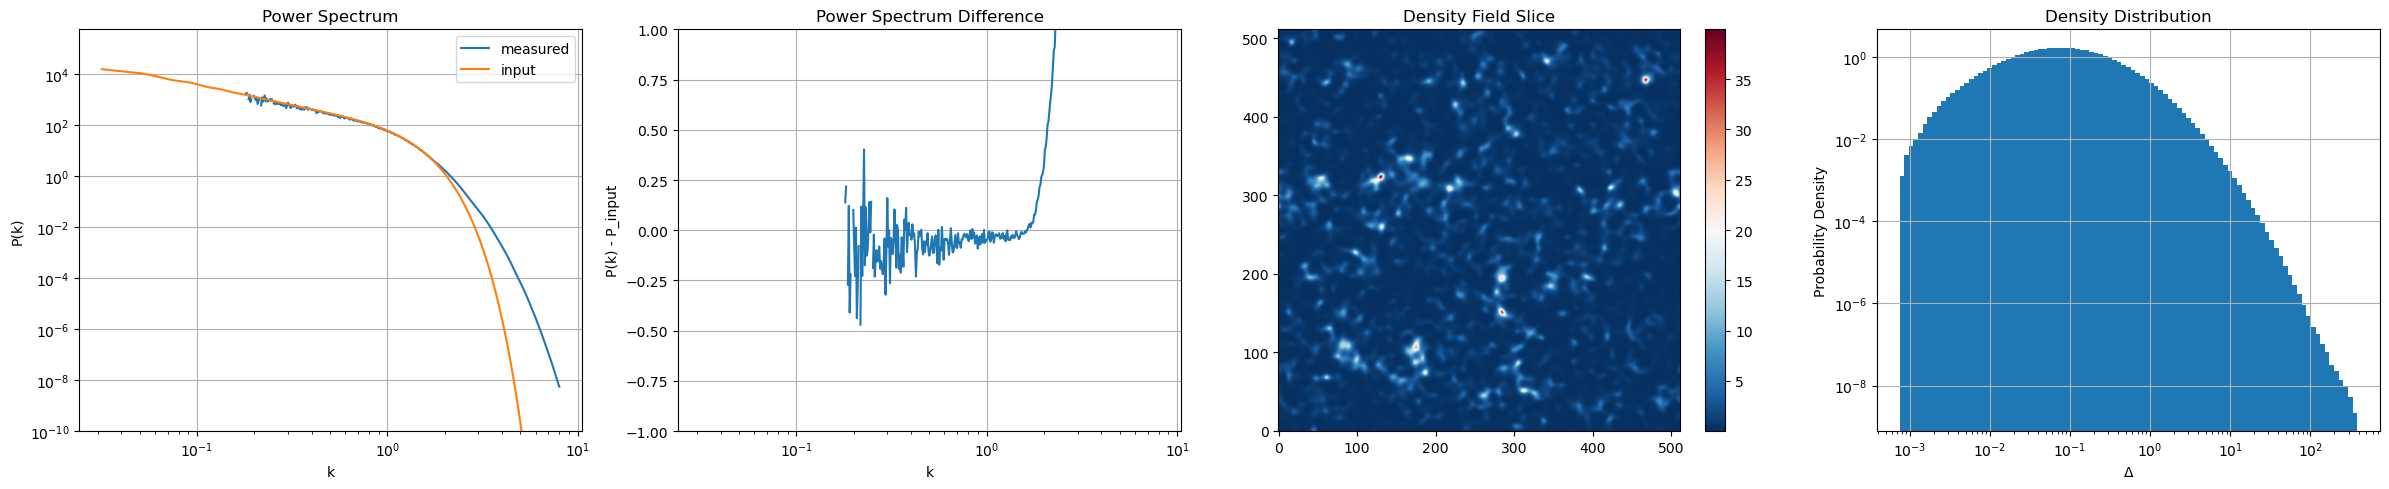

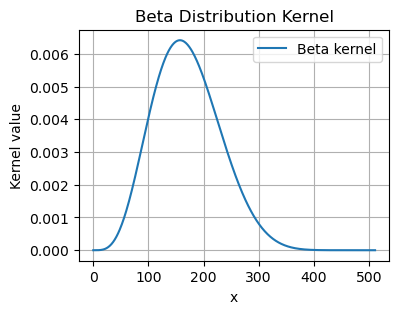

In [28]:
plot_field(Δ, P_input, P_Δ, k_Δ)
plot_kernel(num_pix, kernel)


# Test if the resolution is large enough to have accurate quadratic projection

In [ ]:
smoothing_scale=None
cmax = 30

We will decrease the resolution by a factor of 2 and see if there is any difference in the results.

mean absolute error 0.022240962534445633
max absolute error 16.481451687951903 max value 4274.77313390897
cmin, cmax 0.01 30


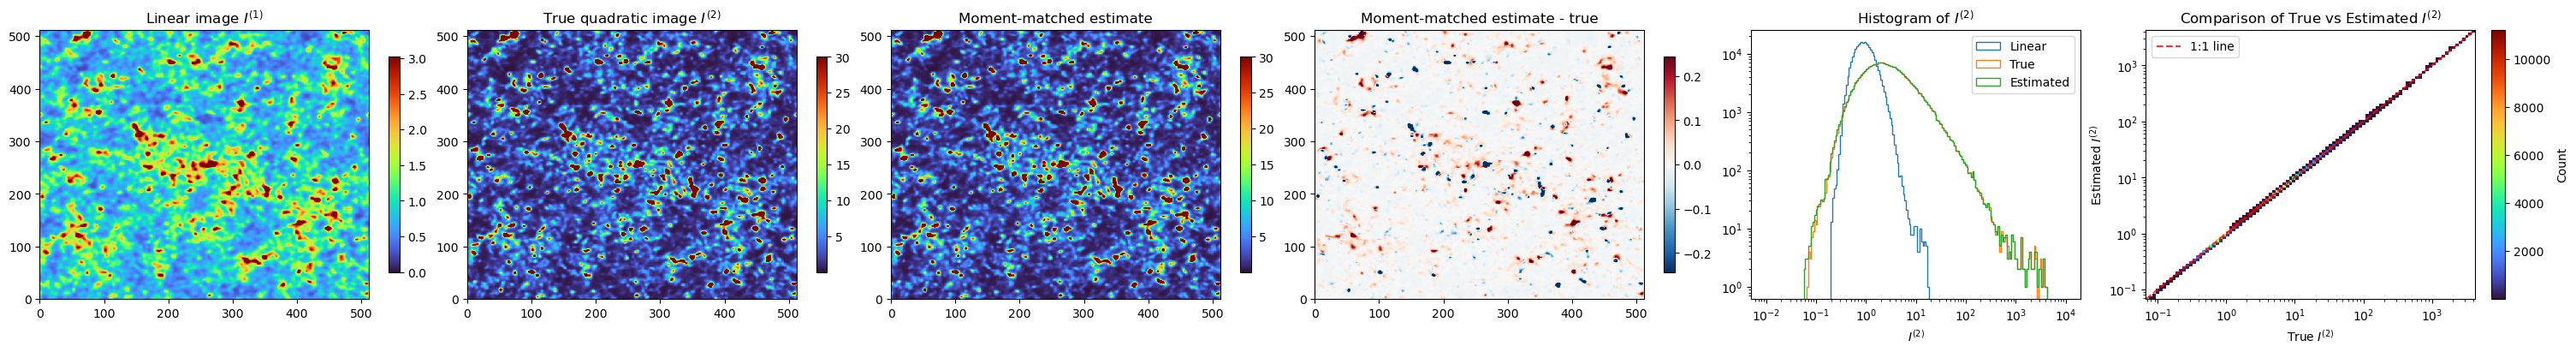

In [30]:
Q_est, Q_true, Q_corr = plot_estimator_for_semgents(Z=256, smoothing_scale=smoothing_scale, cmax=cmax)

$\rightarrow$ The error is very small. The resolution is good enough.

# Variable number of segments

In [46]:
smoothing_scale = 5 # Mpc/h, target smoothing scale of the analysis
cmax = 50

mean absolute error 0.2144592484409889
max absolute error 7.958435270470055 max value 163.8550967727086
cmin, cmax 0.01 50


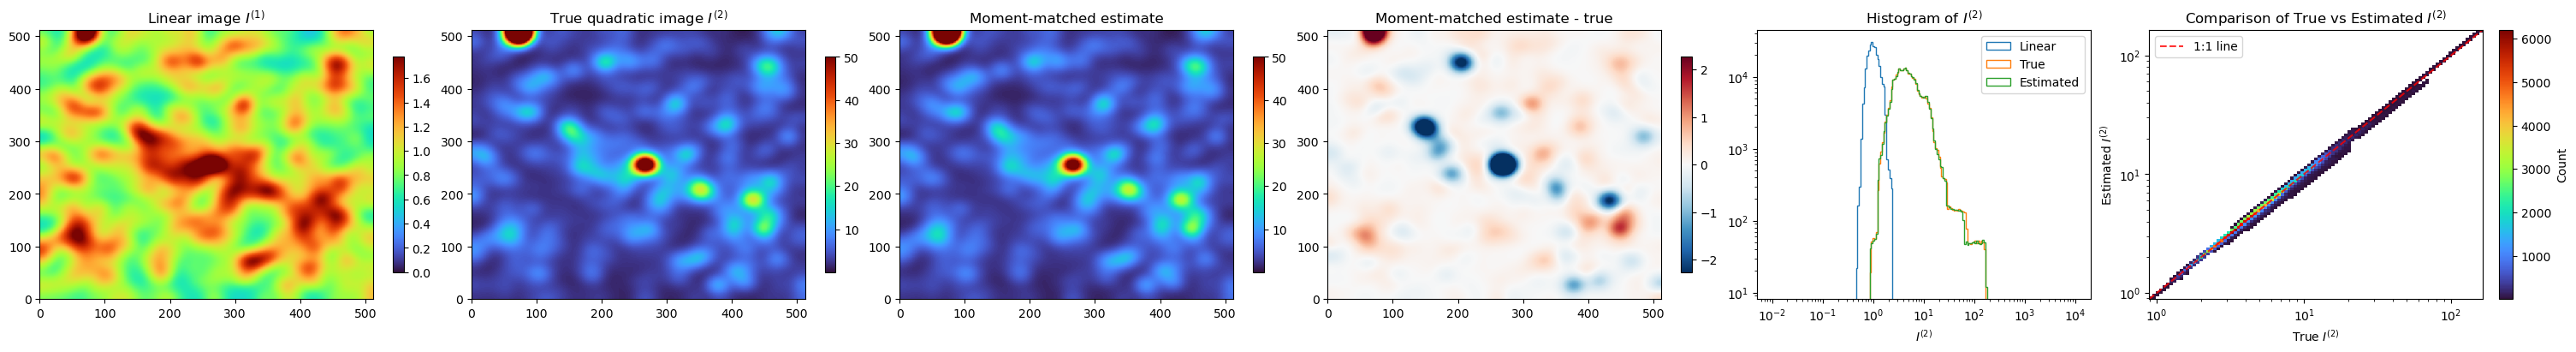

In [47]:
plot_estimator_for_semgents(Z=64, smoothing_scale=smoothing_scale, cmax=cmax, calibr_scale=1);

mean absolute error 0.6157570904507227
max absolute error 10.91267732387854 max value 163.8550967727086
cmin, cmax 0.01 50


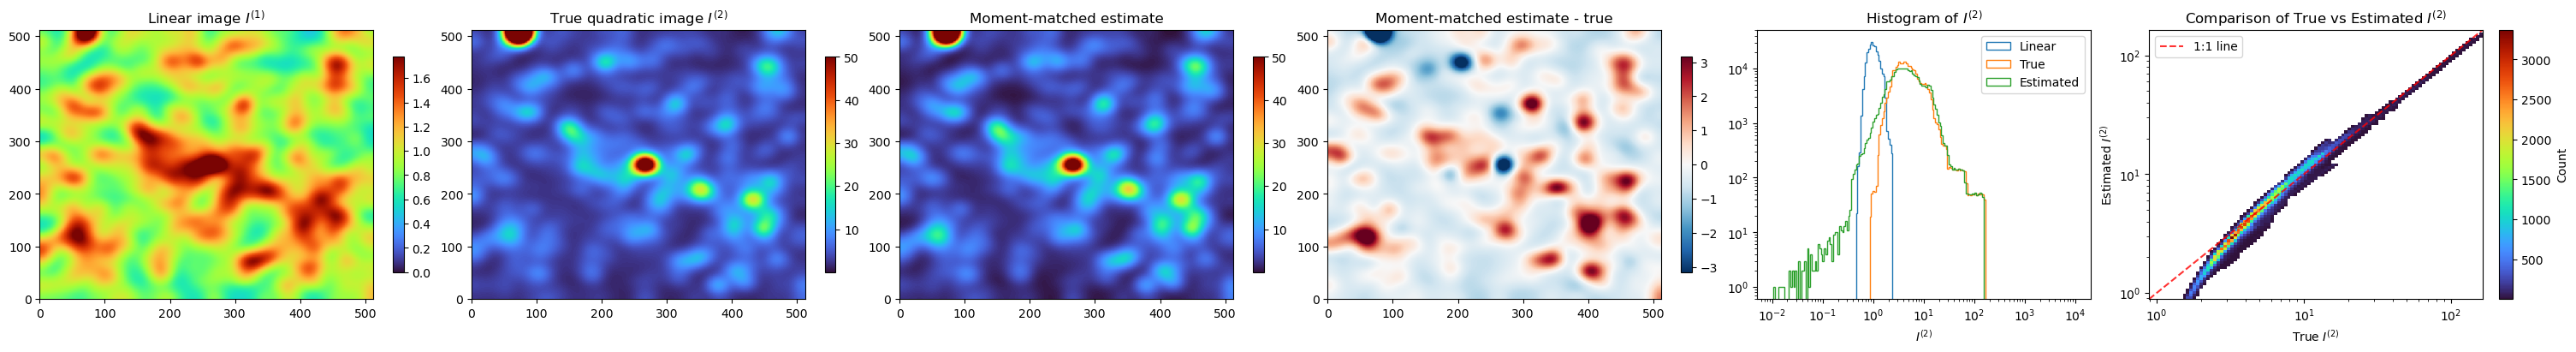

In [48]:
plot_estimator_for_semgents(Z=32, smoothing_scale=smoothing_scale, cmax=cmax, calibr_scale=1);

mean absolute error 0.5612243223381504
max absolute error 19.303509389947607 max value 163.8550967727086
cmin, cmax 0.01 50


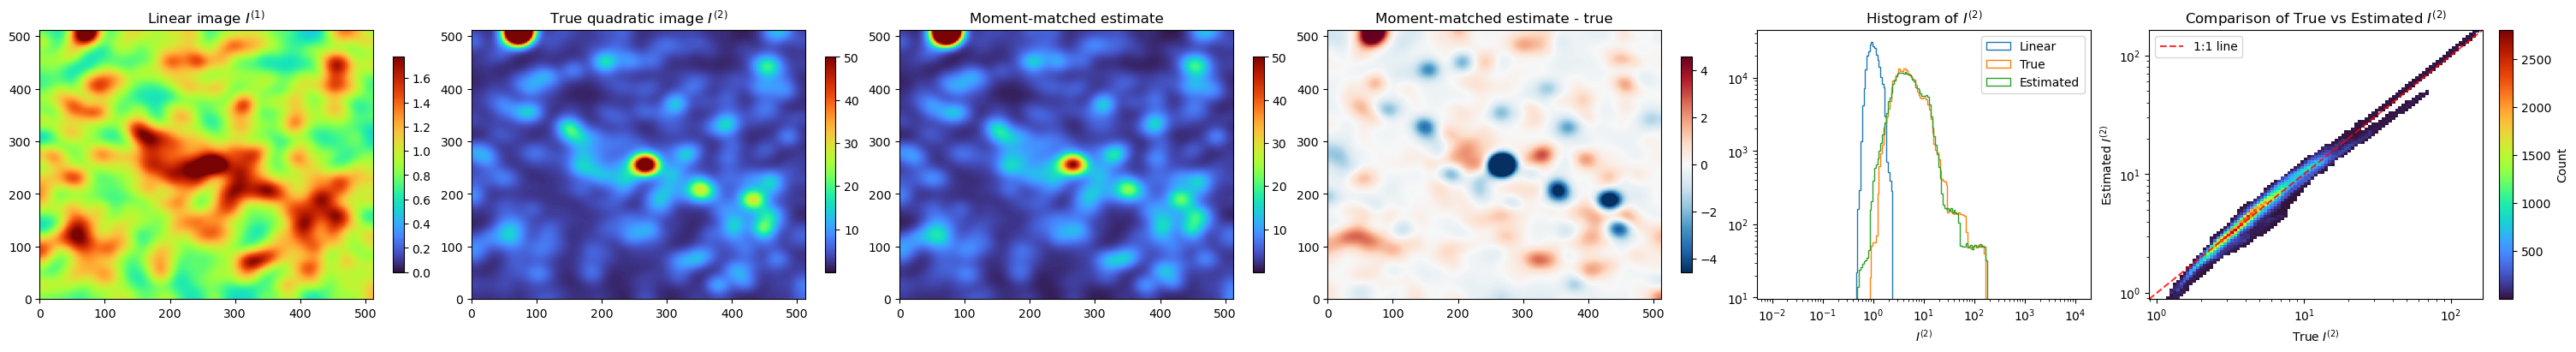

In [49]:
plot_estimator_for_semgents(Z=16, smoothing_scale=smoothing_scale, cmax=cmax, calibr_scale=1);

# Variable segment size

512 [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 16 16 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]
len(Δ_segments) 32
len(kernel_segments) 32
inds_z [  2   5   9  14  20  27  35  44  54  65  77  90 104 119 135 151 167 183 200 218 237 257 278 300 323 347 372 398 425 453 482 512]
seq_lengths [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 16 16 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]
mean absolute error 0.4317485732645994
max absolute error 8.437770838071373 max value 163.8550967727086
cmin, cmax 0.01 50


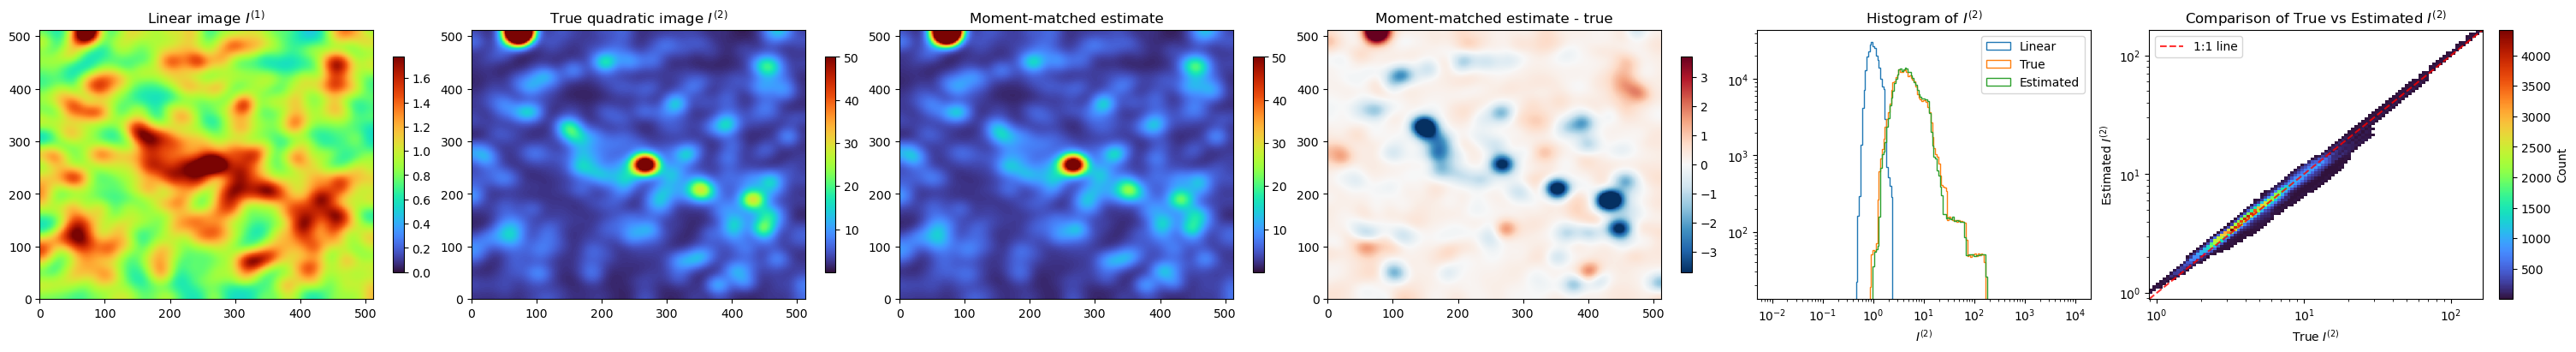

In [50]:
plot_estimator_for_semgents(32, smoothing_scale=smoothing_scale, cmax=cmax, calibr_scale=1, segment_pattern='increasing');

Check what happens if we don't use the shell weight adapted for the shell thickness

512 [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 16 16 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]
len(Δ_segments) 32
len(kernel_segments) 32
inds_z [  2   5   9  14  20  27  35  44  54  65  77  90 104 119 135 151 167 183 200 218 237 257 278 300 323 347 372 398 425 453 482 512]
seq_lengths [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 16 16 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]
mean absolute error 0.5524467863210297
max absolute error 6.754539341001376 max value 163.8550967727086
cmin, cmax 0.01 50


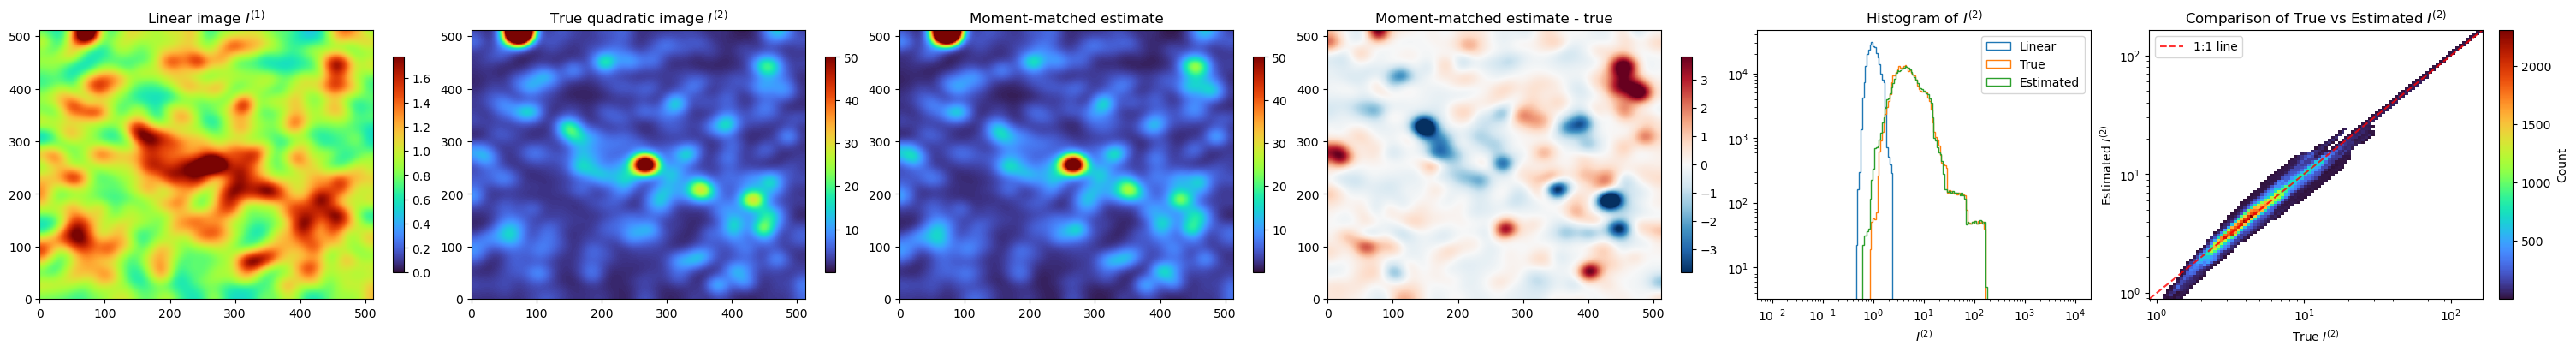

In [51]:
Q_est, Q_true, Q_corr = plot_estimator_for_semgents(32, smoothing_scale=smoothing_scale, cmax=cmax, calibr_scale=1,segment_pattern='increasing', use_flat_estimator=True);

$\rightarrow$ The error increses, as expected!


# Plot lines of sight along each error maximum

Use small number of segments to demonstrate the estimator.

mean absolute error 1.5560974923869029
max absolute error 24.008366739282025 max value 163.8550967727086
cmin, cmax 0.01 50


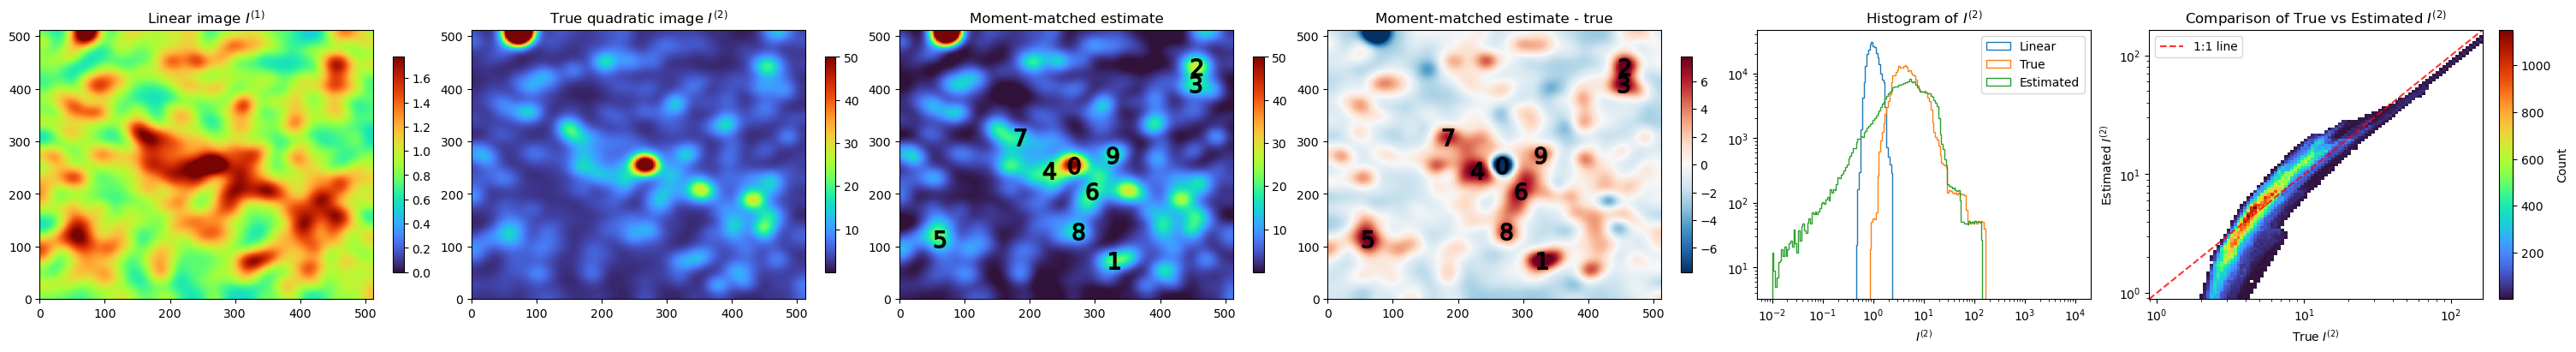

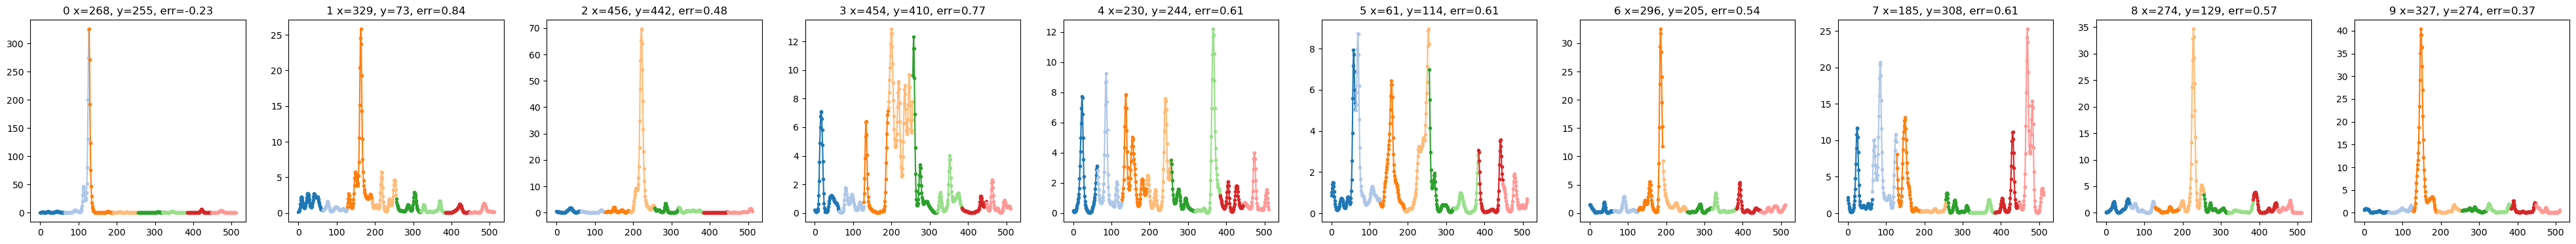

In [52]:
Q_est, Q_true, Q_corr = plot_estimator_for_semgents(Z=8, smoothing_scale=smoothing_scale, cmax=cmax, calibr_scale=1, plot_los=True);